# *refellips* demo: Solid/Aid
This demo presents an example use case for fitting multi-wavelength multi-angle ellipsometry data with *refellips*. This example also demonstrates the use of the provided plotting tools.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
from refnx.analysis import CurveFitter
from refnx.reflect import Slab

In [3]:
from refellips.dataSE import DataSE, open_EP4file
from refellips.reflect_modelSE import ReflectModelSE
from refellips.objectiveSE import ObjectiveSE
from refellips.dispersion import RI, load_material

In [4]:
# Include plotting tools
sys.path.insert(1, "../tools")
from plottools import plot_ellipsdata, plot_structure

### Import data

In [5]:
dname = "WVASE_example_2nmSiO2_20nmPNIPAM_MultiWavelength.txt"
data = DataSE(data=dname)

### Build model

In [6]:
si = load_material("silicon")
sio2 = load_material("silica")
PNIPAM = RI("../refellips/materials/pnipam.csv")
air = RI("../refellips/materials/air.csv")

PNIPAM_layer = PNIPAM(150)
PNIPAM_layer.thick.setp(vary=True, bounds=(100, 500))

struc = air() | PNIPAM_layer | sio2(20) | si()

model = ReflectModelSE(struc)

# Fitting experimental data

### Model & data pre fit

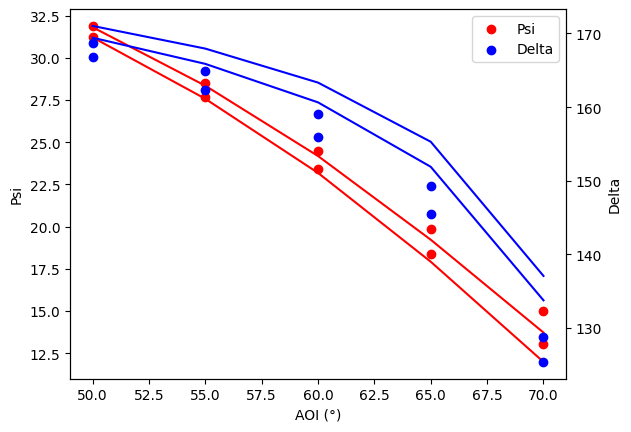

In [7]:
fig, ax = plt.subplots()
axt = ax.twinx()

for idx, wav in enumerate(np.unique(data.wavelength)):
    wavelength, aoi, d_psi, d_delta = list(data.unique_wavelength_data())[idx]

    psi, delta = model(np.c_[np.ones_like(aoi) * wavelength, aoi])
    ax.plot(aoi, psi, color="r")
    axt.plot(aoi, delta, color="b")

    p = ax.scatter(aoi, d_psi, color="r")
    d = axt.scatter(aoi, d_delta, color="b")

ax.legend(handles=[p, d], labels=["Psi", "Delta"])
ax.set(ylabel="Psi", xlabel="AOI (°)")
axt.set(ylabel="Delta");

In [8]:
objective = ObjectiveSE(model, data)

In [9]:
objective.residuals()

array([-0.07547974, -0.1496328 , -0.29647782, -0.60511961, -1.2947233 ,
       -0.04719769, -0.10277092, -0.21800447, -0.46969194, -1.08630119,
        2.63880081,  3.49501976,  4.69717526,  6.41637395,  8.36679892,
        2.31856671,  3.09963958,  4.22133817,  5.94761618,  8.24880252])

In [10]:
fitter = CurveFitter(objective)
fitter.fit(method="least_squares");

### Model & data post fit

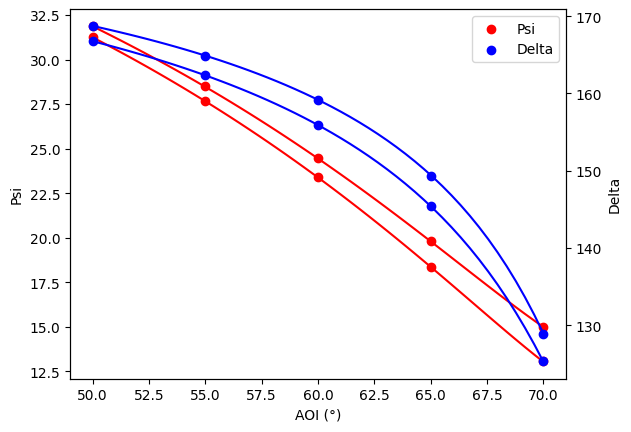

In [11]:
fig, ax = objective.plot()

In [12]:
for i, x in enumerate(objective.model.parameters):
    print(x)

________________________________________________________________________________
Parameters: 'instrument parameters'
<Parameter:'delta offset' , value=0 (fixed)  , bounds=[-inf, inf]>
________________________________________________________________________________
Parameters: 'Structure - ' 
________________________________________________________________________________
Parameters:       ''       
<Parameter:  ' - thick'   , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter:  ' - rough'   , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter:' - volfrac solvent', value=0 (fixed)  , bounds=[0.0, 1.0]>
________________________________________________________________________________
Parameters:       ''       
<Parameter:  ' - thick'   , value=193.93 +/- 0.144, bounds=[100.0, 500.0]>
<Parameter:  ' - rough'   , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter:' - volfrac solvent', value=0 (fixed)  , bounds=[0.0, 1.0]>
_______________________________________________________________________

## Using the plotting tools

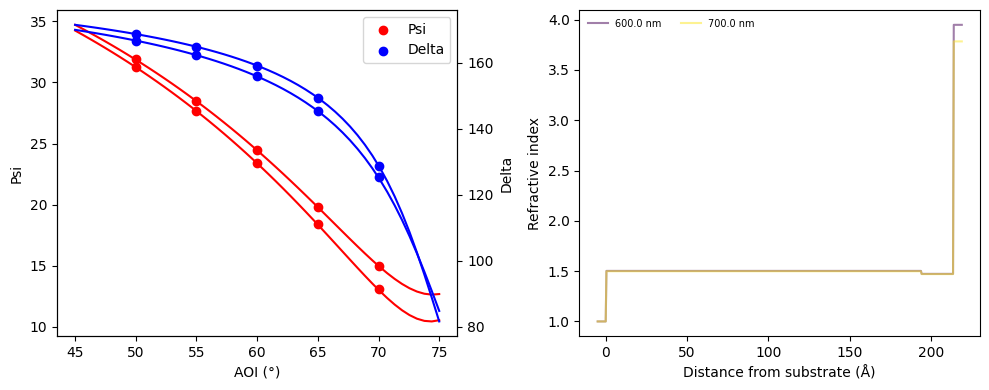

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

plot_ellipsdata(ax[0], data=data, model=model, xaxis="aoi")
plot_structure(ax[1], objective=objective)

fig.tight_layout()